# One Layer DNN (Pima Diabetes Dataset)

### Import modules

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import tensorflow as tf

### Define Input and Output

In [2]:
pima = np.loadtxt('./pima-indians-diabetes.data', delimiter=',')

##Attribute Information:
#1. Number of times pregnant
#2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
#3. Diastolic blood pressure (mm Hg)
#4. Triceps skin fold thickness (mm)
#5. 2-Hour serum insulin (mu U/ml)
#6. Body mass index (weight in kg/(height in m)^2)
#7. Diabetes pedigree function
#8. Age (years)
#9. Class variable (0 or 1)

### Preprocess the data

In [3]:
pima[np.where(pima[:,0]>8),0] = 8 #Pregnancy-more than 8 should be taken as 8
pima[np.where(pima[:,7]<=30),7] = 1 #quantize the age in 5 buckets
pima[np.where((pima[:,7]>30) & (pima[:,7]<=40)),7] = 2
pima[np.where((pima[:,7]>40) & (pima[:,7]<=50)),7] = 3
pima[np.where((pima[:,7]>50) & (pima[:,7]<=60)),7] = 4
pima[np.where(pima[:,7]>60),7] = 5

### Create X and Y data

In [4]:
X = pima[:, [1, 5]]  #we will use two variables only for simplicity.
y = pima[:,8:9]
print('Class labels:', np.unique(y))


# Splitting data into 70% training and 30% test data:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                    random_state=1, stratify=y)
y_train = np.array(y_train.ravel())
y_test = np.array(y_test.ravel())

## Standardizing the features:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Class labels: [0. 1.]


### Train using Tensorflow

In [5]:
feature_columns =[tf.feature_column.numeric_column("x",shape=[np.shape(X)[1]])]

classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                        #hidden_units=[5,10,5], n_classes=2, model_dir="./model")
                                        hidden_units=[5,10,5], n_classes=2, model_dir= None)

def train_input_fn():
    return {"x":np.array(X_train_std)},np.array(y_train,dtype=np.int)

classifier.train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpbpru64_y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A6E2C0A248>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for u

### Evaluate the data

In [6]:
def test_input_fn():
    return {"x":np.array(X_test_std)},np.array(y_test,dtype=np.int)
accuracy_score = classifier.evaluate(input_fn=test_input_fn,steps=1)["accuracy"]
print("Test Accuracy: {0:f}".format(accuracy_score))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-13T11:51:17Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Asus\AppData\Local\Temp\tmpbpru64_y\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2020-09-13-11:51:18
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.73593074, accuracy_baseline = 0.64935064, auc = 0.79090536, auc_precision_recall = 0.6615205, average_loss = 0.53718764, global_step = 1000, label/mean = 0.35064936, loss = 124.09034, precision = 0.67241377, prediction/mean = 0.32931995, recall = 0.4814815
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\Asus\AppData\Local\Temp\tmpbpru64_y\model.ckpt-1000
Test Accuracy: 0.73593

### Define the plotting function

In [7]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.2):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": np.array([xx1.ravel(), xx2.ravel()]).T},
                                                          num_epochs=1,shuffle=False)
        
    print('start predict')
    predictions= list(classifier.predict(input_fn=predict_input_fn))
    print('end predict')
    
    Z= [p["classes"] for p in predictions]  
    Z=np.array(Z)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8,
                    c=colors[idx], marker=markers[idx], label=cl, edgecolor='black')

    if test_idx:   # # highlight test samples.
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black', alpha=1.0,
                    linewidth=1,
                    marker='o', s=100, label='test set')

### Plot the decision boundary

start predict
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Asus\AppData\Local\Temp\tmpbpru64_y\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
end predict


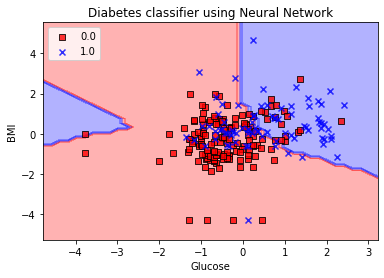

In [8]:
plot_decision_regions(X_test_std, y_test, classifier=classifier)

plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.legend(loc='upper left')
plt.title('Diabetes classifier using Neural Network')
plt.show()